In [ ]:
!pip install -q pydicom

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import numpy as np
import pandas as pd
import csv
from PIL import Image
import time
import cv2
from sklearn.utils import shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.layers.core import Dropout, Activation
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Dense
from keras.initializers import TruncatedNormal
from keras.regularizers import l1, l2
from keras.utils import to_categorical

C:\Users\prash\Anaconda3\envs\expts\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\prash\Anaconda3\envs\expts\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\prash\Anaconda3\envs\expts\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\prash\Anaconda3\envs\expts\lib\site-packages\tensorflow\python\f

In [3]:
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
# from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
# from keras_preprocessing.image import ImageDataGenerator

In [4]:
import pydicom
from pydicom.data import get_testdata_files

In [5]:
train_filepath = "dataset/RSNA_training_processed.csv"
df = pd.read_csv(train_filepath)
df.shape

(674262, 7)

In [6]:
lines = []
d = dict()
for file in ['RSNA0', 'RSNA0EXT', 'RSNA1', 'RSNA2', 'RSNA3', 
             'RSNA4', 'RSNA5']:
    with open( 'dataset/' + file + '.csv') as f:
        path_lines = f.read().splitlines()
        for i in range(len(path_lines)):
            path_lines[i] = path_lines[i].split(".")[0]
    lines = lines + path_lines
    d[file] = set(path_lines)
    print(path_lines[0])


ID_63eb1e259
ID_000fb4d56
ID_e732e6d17
ID_2124519bc
ID_fac4426fa
ID_5fc337950
ID_aeda0804d


In [7]:
len(lines)

10000

In [8]:
d.keys()

dict_keys(['RSNA0', 'RSNA0EXT', 'RSNA1', 'RSNA2', 'RSNA3', 'RSNA4', 'RSNA5'])

In [9]:
line = lines[0]
print(line)
lin = line.split(".")[0]
print(lin)

ID_63eb1e259
ID_63eb1e259


In [10]:
for i, line in enumerate(lines):
    lines[i] = line.split(".")[0]

In [11]:
sample_df = df.loc[df['ID'].isin(lines)]

In [12]:
# tdf = sample_df[:10]
for i, row in sample_df.iterrows():
    filename = row['ID']
    for key in d.keys():
        if filename in d[key]:
            sample_df.at[i,'ID'] = key + '/' + filename

In [13]:
sample_df_shuffled = shuffle(sample_df)

In [14]:
sample_df_shuffled.head()

,ID,1,2,3,4,5,label
4927,RSNA0EXT/ID_f8d32f93b,0,0,0,0,0,0
11646,RSNA5/ID_d05a0f809,0,0,0,0,1,1
17125,RSNA4/ID_a9544ac63,0,0,0,1,0,1
4164,RSNA0EXT/ID_721f4fcdc,0,0,0,0,0,0
5388,RSNA0EXT/ID_7204fab5d,0,0,0,0,0,0


In [15]:
splitdf_index1 = round(0.8 * len(sample_df_shuffled))
print(splitdf_index1)

train_df = sample_df_shuffled[ : splitdf_index1]
validate_df = sample_df_shuffled[splitdf_index1 : ]

8000


In [16]:
train_list = train_df[train_df.columns[0]].tolist()
validate_list = validate_df[validate_df.columns[0]].tolist()
train_label_list = train_df[train_df.columns[6]].tolist()
validate_label_list = validate_df[validate_df.columns[6]].tolist()

In [22]:
%load_ext cython

In [23]:
%%cython -a
import cython

@cython.boundscheck(False)
cpdef float[:, :] threshold_fast(int T1, int T2, float [:, :] image):
    # set the variable extension types
    cdef int x, y, w, h
    
    # grab the image dimensions
    h = image.shape[0]
    w = image.shape[1]
    
    # loop over the image
    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            image[y, x] = image[y, x] if (image[y, x] >= T1 and image[y, x] <= T2) else 0
    
    # return the thresholded image
    return image

In [20]:
def window_image(img, window_center,window_width, intercept, slope):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

# generates batches of images to be fed into the model
def myGenerator(image_lines, label_lines, batch_size):
    num_samples = len(image_lines)
    X_return = []
    y_return = []
    
    while True:
        for offset in range(0, num_samples, batch_size):
            images = []
            labels = []
            temp_line = image_lines[offset:offset+int(batch_size)]
            temp_line_label = label_lines[offset:offset+int(batch_size)]

            for index in range(0, len(temp_line)):
                source_path = temp_line[index]
                filename = 'dataset/' + source_path + '.dcm'
                current_path = filename
                
                # Load the image
                try:
                    ds = pydicom.dcmread(filename)
                except:
                    continue
                # get pixel values from the read DICOM file
#                 image_single = ds.pixel_array
                
                # perform windowing
#                 window_center , window_width, intercept, slope = get_windowing(ds)
#                 image_windowed = window_image(image_single, window_center, window_width, intercept, slope)
                
                #  resize the image
#                 image_windowed_float = image_windowed.astype(np.float32)
#                 image_windowed_resized = cv2.resize(image_windowed_float, dsize=(224, 224))
                
                # thresholding to include hounsfield values for blood
#                 thresh = threshold_fast(40, 66, image_windowed_resized)
#                 thresh2 = threshold_fast(0, 90, image_windowed_resized)
                
                
                # stack thrice for 3 channels
#                 image = np.stack([image_windowed_resized, thresh, thresh2])
#                 image = np.stack([image_windowed_resized, image_windowed_resized, image_windowed_resized])
                
                # converting to channels_last
#                 image = np.moveaxis(image, 0, 2)

                image = bsb_window(ds)

                images.append(image)
              
                label = to_categorical(temp_line_label[index], num_classes=2)
                labels.append(label)


            X_return = np.asarray(images)
            y_return = np.asarray(labels)

            yield shuffle(X_return, y_return)


In [31]:
# Constants
TEST_SIZE = 0.02
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 64
SHAPE = (HEIGHT, WIDTH, CHANNELS)

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image_bsb(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image_bsb(dcm, 40, 80)
    subdural_img = window_image_bsb(dcm, 80, 200)
    soft_img = window_image_bsb(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

def subdural(dcm):
    subdural_img = window_image_bsb(dcm, 80, 200)
    subdural_img = (subdural_img - (-20)) / 200
    return subdural_img

def brain(dcm):
    brain_img = window_image_bsb(dcm, 40, 80)
    brain_img = (brain_img - 0) / 80
    return brain_img

This cell is for looking at the DICOM files

dataset/RSNA2/ID_c73a099c0.dcm


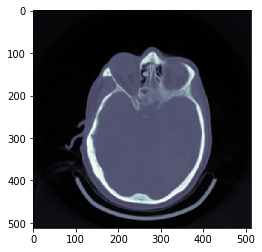

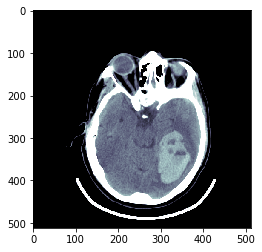

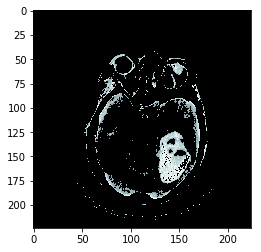

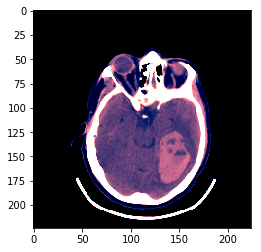

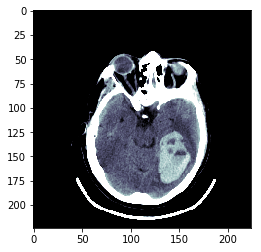

In [61]:
# source_path = train_list[2] # use index 2 to for the image P wants
for source_path in validate_list[53:54]:
    filename = 'dataset/' + source_path + '.dcm'
    current_path = filename
    print(current_path)

    ds = pydicom.dcmread(filename)
    
    plt.figure()
    plt.imshow(ds.pixel_array, cmap = plt.cm.bone)

    image_single = ds.pixel_array
    window_center , window_width, intercept, slope = get_windowing(ds)
    image_windowed = window_image(image_single, window_center, window_width, intercept, slope)
    
    # # Convert to uint
    # image_2d_scaled = np.uint8(image_2d_scaled)

    plt.figure()
    plt.imshow(image_windowed, cmap = plt.cm.bone)
    
    image_windowed_float = image_windowed.astype(np.float32)
    
    image_windowed_resized = cv2.resize(image_windowed_float, dsize=(224, 224))
    
    # thresholding to include hounsfield values from -150 to +150    

    thresh = threshold_fast(40, 66, image_windowed_resized)  
    plt.figure()
    plt.imshow(thresh, cmap =plt.cm.bone) 
    
#     print(type(np.array(thresh)))
    thresh1 = bsb_window(ds)  
    plt.figure()
    plt.imshow(thresh1, cmap =plt.cm.bone) 
    

    thresh2 = brain(ds)
    plt.figure()
    plt.imshow(thresh2, cmap =plt.cm.bone) 

#     savefile_name = "images/" + source_path + ".png"
#     plt.imsave(savefile_name, ds.pixel_array, cmap='gray')

In [21]:
a = np.array([[1,2,3],[4,5,6], [7,8,9]])
a = a.astype(np.float32)
a

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]], dtype=float32)

In [72]:
b = cv2.resize(a, dsize=(2, 2))
b

array([[2. , 3.5],
       [6.5, 8. ]], dtype=float32)

In [36]:
np.savetxt('image_windowed.txt', image_windowed)
np.savetxt('image_windowed_single.txt', image_windowed_single)

In [65]:
np.min(image_windowed)

76

In [66]:
np.min(image_windowed_resized)

0

In [14]:
validate_df.head()

,ID,1,2,3,4,5,label
3478,RSNA0EXT/ID_d2d243c32,0,0,0,0,0,0
30340,RSNA2/ID_db79c02f9,0,1,0,0,0,1
3331,RSNA0EXT/ID_8301f4b60,0,0,0,0,0,0
7500,RSNA5/ID_2077e39ca,0,0,0,0,1,1
12025,RSNA5/ID_63b3ee44c,0,0,0,0,1,1


Load a predefined model into 'base_model'

In [33]:
base_model = keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
                                                         include_top=False, weights='imagenet', input_tensor=None, 
                                                         pooling=None)

In [34]:
# for layer in base_model.layers[: 150]: 
#     layer.trainable = False 

for layer in base_model.layers: 
    layer.trainable = True

x = base_model.output

x = GlobalAveragePooling2D()(x) # GAP

x = Dropout(0.5)(x)

x = Dense(500)(x)               # Dense 1
x = Activation('relu')(x)

x = Dropout(0.5)(x)

x = Dense(200)(x)               # Dense 2
x = Activation('relu')(x)

x = Dropout(0.5)(x)

x = Dense(50)(x)               # Dense 3
x = Activation('relu')(x)

x = Dropout(0.5)(x)

predictions = Dense(2, activation='softmax')(x) # Dense 4

model_PrashNet = Model(inputs=base_model.input, outputs=predictions)

model_PrashNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [35]:
sgd = SGD(lr=0.0001, momentum=0.9, decay=1e-6, nesterov=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_PrashNet.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 2, verbose = 1,min_lr = 1e-7)
timeasname = time.asctime(time.localtime(time.time())).replace(" ", "-").replace(":", "-")
modelname = "inception_thresh"
weights = "imagenet"
optimizer= "adam"
specs = modelname + '_' + weights + '_' + optimizer
weight_path="weights/{}_{}_weights.best.hdf5".format(specs, timeasname)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

# tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(timeasname),
#                                           histogram_freq=0, write_graph=True, write_images=True)

# csvlogger = keras.callbacks.CSVLogger("epochlogs/{}_{}".format(specs, timeasname), separator=',', append=False)                                          
                                          
# earlyStop = EarlyStopping(monitor='val_loss',min_delta=0,
#                               patience=5,
#                               verbose=0, mode='auto')

# callbacks_list = [checkpoint, reduce_lr, tensorboard, csvlogger]
# callbacks_list = [checkpoint, reduce_lr, csvlogger]
callbacks_list = [checkpoint, reduce_lr]

In [36]:
batch_size = 32

train_gen = myGenerator(train_list, train_label_list, batch_size)
valid_gen = myGenerator(validate_list, validate_label_list, batch_size)

In [37]:
hist = model_PrashNet.fit_generator(train_gen,
                           int((len(train_list))/batch_size),
                           epochs = 20,verbose=1, 
                           callbacks=callbacks_list,
                           validation_data = valid_gen,
                           validation_steps = int((len(validate_list))/batch_size))

Epoch 1/20
250/250 [==============================] - 303s 1s/step - loss: 0.7102 - acc: 0.5930 - val_loss: 7.0301 - val_acc: 0.5373

Epoch 00001: val_loss improved from inf to 7.03010, saving model to weights/inception_thresh_imagenet_adam_Mon-Nov-25-21-34-55-2019_weights.best.hdf5
Epoch 2/20
250/250 [==============================] - 223s 890ms/step - loss: 0.5866 - acc: 0.7241 - val_loss: 2.1498 - val_acc: 0.7414

Epoch 00002: val_loss improved from 7.03010 to 2.14981, saving model to weights/inception_thresh_imagenet_adam_Mon-Nov-25-21-34-55-2019_weights.best.hdf5
Epoch 3/20
250/250 [==============================] - 175s 698ms/step - loss: 0.5356 - acc: 0.7421 - val_loss: 1.9818 - val_acc: 0.6754

Epoch 00003: val_loss improved from 2.14981 to 1.98177, saving model to weights/inception_thresh_imagenet_adam_Mon-Nov-25-21-34-55-2019_weights.best.hdf5
Epoch 4/20
250/250 [==============================] - 169s 674ms/step - loss: 0.5102 - acc: 0.7611 - val_loss: 2.0158 - val_acc: 0.502

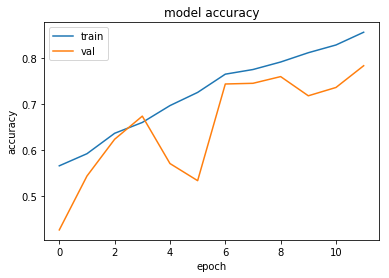

In [106]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

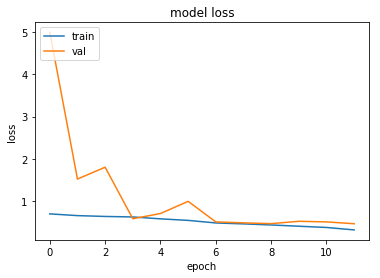

In [107]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Save weights if you want

In [29]:
timeasname = time.asctime(time.localtime(time.time())).replace(" ", "-").replace(":", "-")

modelname = "inception_nothresh"

weights = "imagenet"

optimizer= "adam"

specs = modelname + '_' + weights + '_' + optimizer

weight_path="weights/{}_{}_weights.last.hdf5".format(specs, timeasname)

In [30]:
model_PrashNet.save_weights(weight_path)

load weights - inception

In [110]:
model_PrashNet.load_weights("weights/inception_thresh_imagenet_adam_Sun-Nov-24-16-22-21-2019_weights.best.hdf5")

In [39]:
# test_data = validate_df.
testinfo_df = validate_df.copy(deep=True)
# testinfo_df['GroundTruth'] = ""
# testinfo_df['Predicted'] = ""


In [40]:
testinfo_df.head()

,ID,1,2,3,4,5,label
11055,RSNA2/ID_5bf3233c7,0,1,0,0,0,1
1323,RSNA1/ID_d86eb94a8,1,0,0,0,0,1
3216,RSNA0EXT/ID_2b7c56075,0,0,0,0,0,0
4131,RSNA0EXT/ID_651637437,0,0,0,0,0,0
5806,RSNA0EXT/ID_224e87fe6,0,0,0,0,0,0


In [56]:
no_of_lines = len(testinfo_df)
# no_of_lines = 800
gt = []
preds = []
probs = []
probs_positive = []
cgt, cprobs = [], []
count, c2 = 0, 0
for index in range(0, no_of_lines):
    source_path = testinfo_df.iloc[index]['ID']
    filename = 'dataset/' + source_path + '.dcm'

    # Load the image
    try:
        ds = pydicom.dcmread(filename)
    except:
        continue
    # get pixel values from the read DICOM file
#     image_single = ds.pixel_array

    # perform windowing
#     window_center , window_width, intercept, slope = get_windowing(ds)
#     image_windowed = window_image(image_single, window_center, window_width, intercept, slope)

    #  resize the image
#     image_windowed_float = image_windowed.astype(np.float32)
#     image_windowed_resized = cv2.resize(image_windowed_float, dsize=(224, 224))

    # thresholding to include hounsfield values for blood
#     thresh = threshold_fast(40, 66, image_windowed_resized)
#     thresh2 = threshold_fast(0, 90, image_windowed_resized)


    # stack thrice for 3 channels
#     image = np.stack([image_windowed_resized, thresh, thresh2])
#     image = np.stack([image_windowed_resized, image_windowed_resized, image_windowed_resized])


    # converting to channels_last
#     image = np.moveaxis(image, 0, 2)
        
    image = bsb_window(ds)
                
    X = model_PrashNet.predict(np.array(image, ndmin = 4))
#     print(X)
    predicted_prob = np.max(X)
    predicted_prob_positive = X[0][1]
    predicted_class = np.argmax(X)
#     print("predicted class: ", predicted_class)
    actual_class = testinfo_df.iloc[index]['label']
#     print("actual class: ", actual_class)
#     testinfo_df.at[index, "GroundTruth"] = actual_class
#     testinfo_df.at[index, 'Predicted'] = predicted_class
    preds.append(predicted_class)
    gt.append(actual_class)
    probs.append(predicted_prob)
    probs_positive.append(predicted_prob_positive)
    if predicted_class == actual_class:
        count = count + 1
        cprobs.append(predicted_prob)
        cgt.append(actual_class)
#         if predicted_prob > 0.75:
#             cprobs.append(predicted_prob)
#             cgt.append(actual_class)
            
print(count, c2, no_of_lines, count/no_of_lines)

1709 0 2000 0.8545


In [57]:
metrics.f1_score(gt, preds)

0.8579795021961933

In [58]:
len(cprobs)

1709

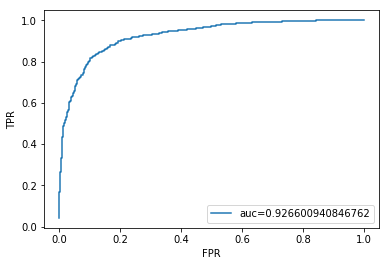

0.926600940846762


In [59]:
fpr, tpr, thresholds = metrics.roc_curve(gt, probs_positive)
auc = metrics.roc_auc_score(gt,probs_positive)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.ylabel('TPR')
plt.xlabel('FPR')
# plt.axis('scaled')
plt.show()
print(auc)

save the arrays along with validate_df

In [69]:
array_path="{}_{}.txt".format(specs, timeasname)
np.savetxt('arrays/preds' + '_' + array_path, preds)
np.savetxt('arrays/probs' + '_' + array_path, probs)
np.savetxt('arrays/gt' + '_' + array_path, gt)
np.savetxt('arrays/cprobs' + '_' + array_path, cprobs)
np.savetxt('arrays/cgt' + '_' + array_path, cgt)
np.savetxt('arrays/probs_positive' + '_' + array_path, probs_positive)


In [70]:
sub = testinfo_df.to_pickle("arrays/testinfo_df" + '_' + array_path + ".pkl")

In [56]:
cnf_matrix = metrics.confusion_matrix(preds, gt)

In [57]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.76103896 0.23896104]
 [0.12544379 0.87455621]]


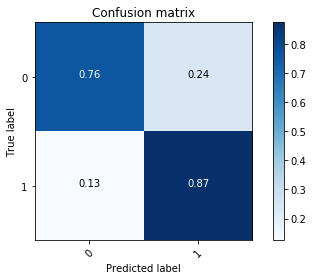

In [58]:
plt.figure()
class_list = list(range(2))
plot_confusion_matrix(cnf_matrix, classes=class_list, normalize=True)

Trying out the trusty mobileNet_v2

In [33]:
from keras.applications import MobileNetV2

In [36]:
base_model = keras.applications.MobileNetV2(input_shape=None, alpha=1.0, 
                                                         include_top=True, weights='imagenet', 
                                                         input_tensor=None, pooling=None)


14540800/14536120 [==============================] - 16s 1us/step


In [37]:
for layer in base_model.layers: 
    layer.trainable = True

x = base_model.output
# x = GlobalAveragePooling2D()(x) # GAP
x = Dropout(0.5)(x)
x = Dense(500)(x)               # Dense 1
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(200)(x)               # Dense 2
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(50)(x)               # Dense 3
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x) # Dense 4
model_PrashNet = Model(inputs=base_model.input, outputs=predictions)
model_PrashNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (Activation)         (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [38]:
sgd = SGD(lr=0.0001, momentum=0.9, decay=1e-6, nesterov=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_PrashNet.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 2, verbose = 1,min_lr = 1e-7)

callbacks_list = [reduce_lr]

In [39]:
hist = model_PrashNet.fit_generator(train_gen,
                           int((len(train_list))/batch_size),
                           epochs = 15,verbose=1, 
                           callbacks=callbacks_list,
                           validation_data = valid_gen,
                           validation_steps = int((len(validate_list))/batch_size))

Epoch 1/15
250/250 [==============================] - 118s 472ms/step - loss: 0.6745 - acc: 0.5755 - val_loss: 0.6801 - val_acc: 0.6087
Epoch 2/15
250/250 [==============================] - 113s 453ms/step - loss: 0.6448 - acc: 0.6580 - val_loss: 0.7954 - val_acc: 0.4731
Epoch 3/15
250/250 [==============================] - 111s 445ms/step - loss: 0.6200 - acc: 0.6791 - val_loss: 0.7376 - val_acc: 0.5600

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/15
250/250 [==============================] - 110s 441ms/step - loss: 0.5668 - acc: 0.7186 - val_loss: 0.7100 - val_acc: 0.6733
Epoch 5/15
250/250 [==============================] - 110s 439ms/step - loss: 0.5496 - acc: 0.7329 - val_loss: 0.6156 - val_acc: 0.7200
Epoch 6/15
250/250 [==============================] - 110s 441ms/step - loss: 0.5261 - acc: 0.7491 - val_loss: 0.5806 - val_acc: 0.7226
Epoch 7/15
250/250 [==============================] - 110s 439ms/step - loss: 0.5066 - acc: 0.7652 - v